In [3]:
import os

import time

from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import optimize

import skimage
from skimage import io
import skimage.exposure as skie
from skimage import transform
from skimage import img_as_float

import napari

In [4]:
in_path = os.getcwd()

In [15]:
tet_img = io.imread(os.path.join(in_path,"220509_TetraSpecks_488_642excite_LP560_zstack.tif"))
tet_max = np.max(tet_img,axis = 0)

print(tet_img.shape)
print(tet_max.shape)

c1 = tet_max[0]
c2 = tet_max[1]

(70, 2, 1280, 1280)
(2, 1280, 1280)


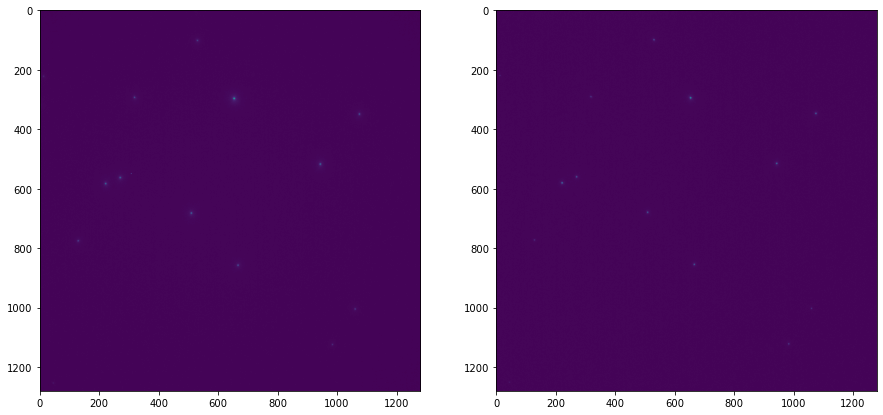

In [16]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,15)
axs[0].imshow(tet_max[0])
axs[1].imshow(tet_max[1])

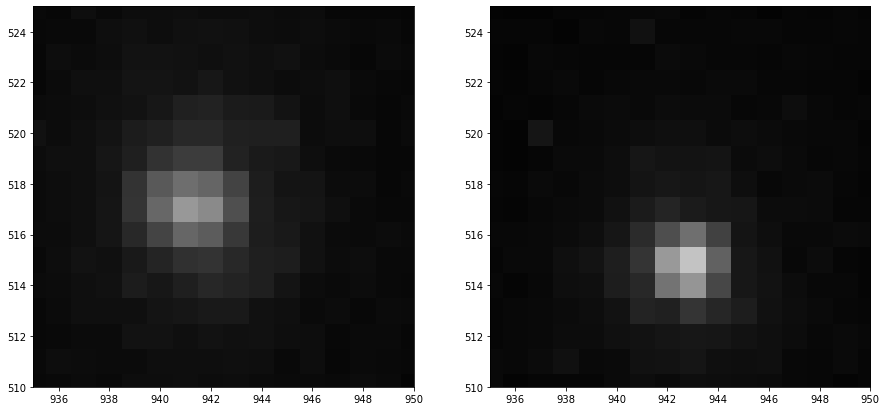

In [26]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,15)

for indx,item in enumerate(axs):
    item.imshow(tet_max[indx], cmap=plt.cm.gray)
    item.set_xlim([935,950])
    item.set_ylim([510,525])

In [20]:
def rescale(img):
    return skie.rescale_intensity(img, in_range = (img.min(),img.max()), out_range = (0,1))

def zscore(arr):
    return (arr - np.mean(arr)) / np.std(arr)

In [21]:
c1_std = zscore(rescale(c1))
c2_std = zscore(rescale(c2))

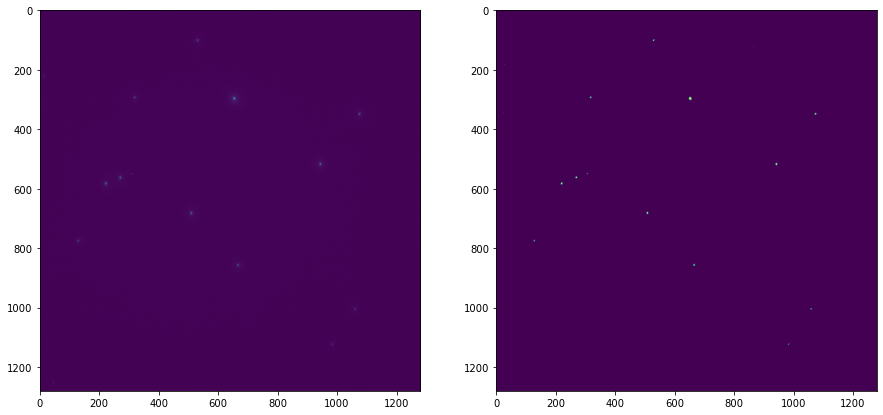

In [30]:
background_mask = np.max([c1,c2],axis=0)
background_mask_threshold = np.where(background_mask > 300., 1, 0)

f, (ax0, ax1) = plt.subplots(1, 2)
f.set_size_inches(15,15)
ax0.imshow(background_mask)
#ax0.set_xlim([310,330])
#ax0.set_ylim([280,300])
ax1.imshow(background_mask_threshold)
#ax1.set_xlim([310,330])
#ax1.set_ylim([280,300])

In [38]:
def mse(arr1, arr2):
    return np.mean((arr1 - arr2)**2)

def mse_where_mask_above_threshold(arr1, arr2, mask, threshold):
    return np.mean((np.ma.masked_where(mask <= threshold, arr1 - arr2))**2)

def make_affine_transform(param):
    r, s, tc, tr, sc, sr = param
    return transform.AffineTransform(rotation=r,
                                         shear=s,
                                         translation=(tc, tr),
                                         scale=(sc, sr))

def cost_mse(param, reference_image, target_image, originals_combined, threshold):
    transformation = make_affine_transform(param)
    transformed = transform.warp(target_image, transformation, order=1, mode='edge')
    return mse_where_mask_above_threshold(reference_image, transformed, originals_combined, threshold)

In [33]:
# optimise parameters starting with identity transform
# reference channel is c1
transformation_params = optimize.minimize(
    cost_mse, [0.,0.,0.,0.,1.,1.], args=(c1_std, c2_std, background_mask, 300), method='Powell'
).x

In [58]:
print(transformation_params)
np.save(os.path.join(in_path,"TransformationParameters.npy"),transformation_params)

[ 3.12435321e-04  6.96874108e-04  1.80463183e+00 -2.28433331e+00
  1.00017084e+00  9.99432054e-01]


In [44]:
trns = make_affine_transform(transformation_params)

In [45]:
c2_transformed = transform.warp(c2,trns, order=0, mode = 'edge', preserve_range=True)

In [49]:
compare = [c1,c2_transformed,c2]
stack = np.stack([rescale(i) for i in compare])
examine = napari.view_image(stack)

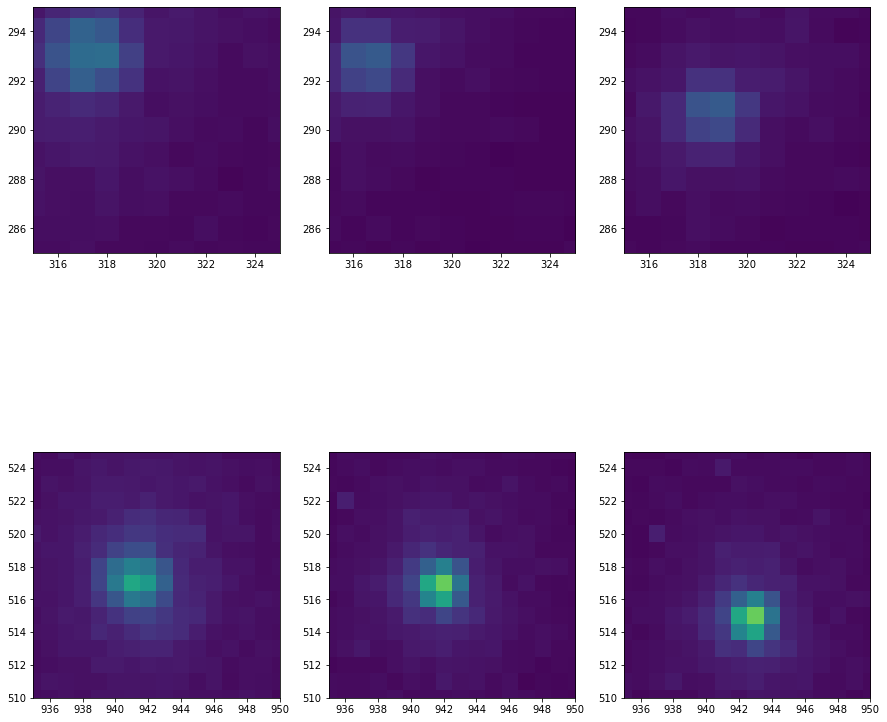

In [57]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,15)

for indx,item in enumerate(axs[0]):
    item.imshow(compare[indx])
    item.set_xlim([315,325])
    item.set_ylim([285,295])

for indx,item in enumerate(axs[1]):
    item.imshow(compare[indx])
    item.set_xlim([935,950])
    item.set_ylim([510,525])

In [78]:
real_img = io.imread(os.path.join(in_path,"220516_chamberslide_Well8_FISH647_DDXRFP_488NHS_DAPI_zstack_005.tif"))
real_img_max = np.max(real_img,axis=0)
print(real_img_max.shape)

real_c2 = real_img_max[:,:,1]
real_c1 = real_img_max[:,:,0]

(1280, 1280, 4)


In [79]:
trns_real_c2 = transform.warp(real_c2,trns, order=0, mode = 'edge', preserve_range=True)

In [80]:
real_imgs = [real_c1,trns_real_c2,real_c2]
stacked = np.stack(real_imgs)

In [81]:
napari.view_image(stacked,channel_axis=0,colormap=["gray","blue","green"])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 639.5, 639.5), zoom=0.497265625, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 1280.0, 1.0), (0.0, 1280.0, 1.0)), current_step=(640, 640), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'Image' at 0x7fdeab251290>, <Image layer 'Image [1]' at 0x7fddd061f790>, <Image layer 'Image [2]' at 0x7fdecc920c10>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBo

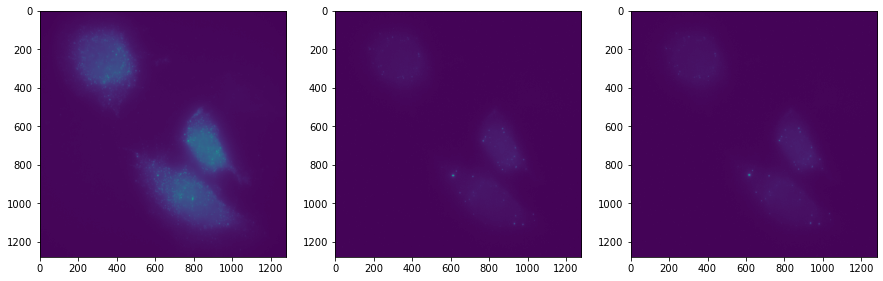

In [88]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3)
f.set_size_inches(15,15)

ax0.imshow(real_c1)
ax1.imshow(trns_real_c2)
ax2.imshow(real_c2)

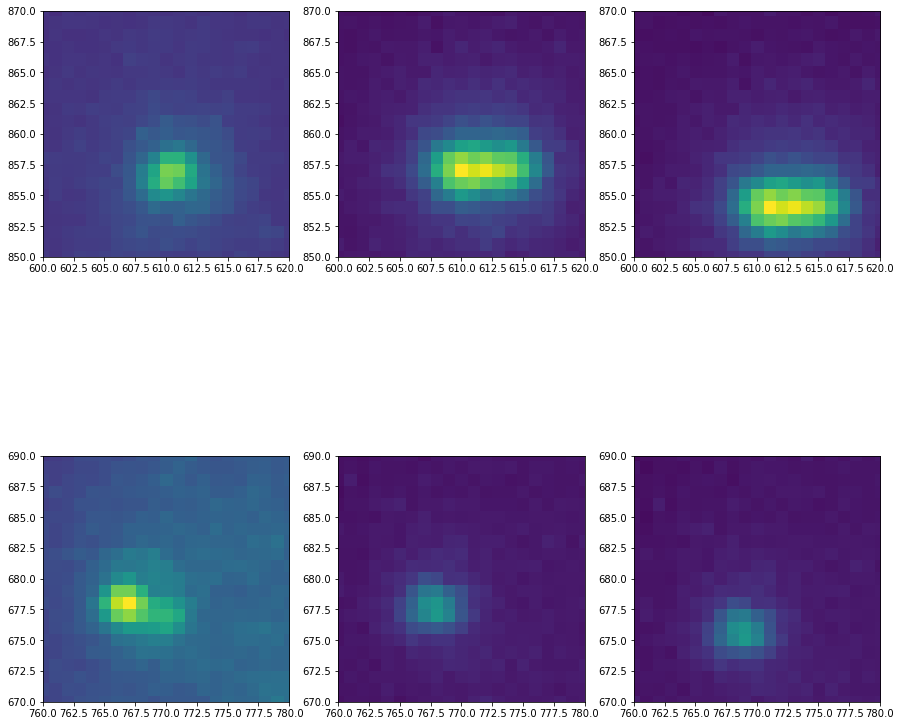

In [93]:
f, axs = plt.subplots(2, 3)
f.set_size_inches(15,15)

for indx,item in enumerate(axs[0]):
    item.imshow(real_imgs[indx])
    item.set_xlim([600,620])
    item.set_ylim([850,870])
    
for indx,item in enumerate(axs[1]):
    item.imshow(real_imgs[indx])
    item.set_xlim([760,780])
    item.set_ylim([670,690])